In [1]:
import time, math, random, bisect, copy
import gym
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from gym import wrappers
import pickle
import car_racing

In [2]:
class NeuralNet : 
    def __init__(self, nodeCount):     
        self.fitness = 0.0
        self.nodeCount = nodeCount
        self.weights = []
        self.biases = []
        for i in range(len(nodeCount) - 1):
            self.weights.append( np.random.uniform(low=-1, high=1, size=(nodeCount[i], nodeCount[i+1])))
            self.biases.append( np.random.uniform(low=-1, high=1, size=(nodeCount[i+1])))

    def printWeightsandBiases(self):
        
        print("--------------------------------")
        print("Weights :\n[", end="")
        for i in range(len(self.weights)):
            print("\n [ ", end="")
            for j in range(len(self.weights[i])):
                if j!=0:
                    print("\n   ", end="")
                print("[", end="")
                for k in range(len(self.weights[i][j])):
                    print(" %5.2f," % (self.weights[i][j][k]), end="")
                print("\b],", end="")
            print("\b ],")
        print("\n]")

        print("\nBiases :\n[", end="")
        for i in range(len(self.biases)):
            print("\n [ ", end="")
            for j in range(len(self.biases[i])):
                    print(" %5.2f," % (self.biases[i][j]), end="")
            print("\b],", end="")
        print("\b \n]\n--------------------------------\n")
    
    def getOutput(self, input):
        output = conv(input)
        for i in range(len(self.nodeCount)-1):
            output = np.matmul(output, self.weights[i]) + self.biases[i]
        return sigmoid(output) * np.array([2., 1., 1.]) + np.array([-1., 0., 0.])
    
    '''
    def getOutput(self, input):
        output = conv(input)
        for i in range(len(self.nodeCount)-1):
            output = np.matmul(output, self.weights[i]) + self.biases[i]
        return np.argmax(output)
    '''

In [3]:
class Population :
    def __init__(self, populationCount, mutationRate, nodeCount):
        self.nodeCount = nodeCount
        self.popCount = populationCount
        self.m_rate = mutationRate
        self.population = [ NeuralNet(nodeCount) for i in range(populationCount)]


    def createChild(self, nn1, nn2):
        
        child = NeuralNet(self.nodeCount)
        for i in range(len(child.weights)):
            s = child.weights[i].shape
            child.weights[i] = np.where(np.random.rand(s[0], s[1]) > self.m_rate, 
                                        np.where(np.random.rand(s[0], s[1]) < nn1.fitness / (nn1.fitness+nn2.fitness), nn1.weights[i], nn2.weights[i]), 
                                        child.weights[i])
            
        for i in range(len(child.biases)):
            s = child.biases[i].shape
            child.biases[i] = np.where(np.random.rand(s[0]) > self.m_rate, 
                                       np.where(np.random.rand(s[0]) < nn1.fitness / (nn1.fitness+nn2.fitness), nn1.biases[i], nn2.biases[i]), 
                                       child.biases[i])
            
        return child


    def createNewGeneration(self):    

        nextGen = []
        self.population.sort(key=lambda x: x.fitness, reverse=True)
        for i in range(self.popCount):
            if random.random() < float(self.popCount-i)/self.popCount:
                nextGen.append(copy.deepcopy(self.population[i]));

        fitnessSum = [0]
        minFit = min([i.fitness for i in nextGen])
        for i in range(len(nextGen)):
            fitnessSum.append(fitnessSum[i]+(nextGen[i].fitness-minFit)**4)
        

        while(len(nextGen) < self.popCount):
            r1 = random.uniform(0, fitnessSum[-1] )
            r2 = random.uniform(0, fitnessSum[-1] )
            nn1 = nextGen[bisect.bisect_right(fitnessSum, r1)-1]
            nn2 = nextGen[bisect.bisect_right(fitnessSum, r2)-1]
            nextGen.append( self.createChild(nn1, nn2) )
        self.population.clear()
        self.population = nextGen

In [4]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

def replayBestBots(bestNeuralNets, steps, sleep):  
    for i in range(len(bestNeuralNets)):
        if i%steps == 0 :
            env.seed(2)
            observation = env.reset()
            print("Generation %3d had a best fitness of %4d" % (i, bestNeuralNets[i].fitness))
            for step in range(MAX_STEPS):
                env.render()
                #time.sleep(sleep)
                action = bestNeuralNets[i].getOutput(observation)
                observation, reward, done, info = env.step(action)
                if done:
                    env.seed(2)
                    observation = env.reset()
                    break
            print("Steps taken =", step)

In [5]:
def pool(image, n, measure):
    assert(image.ndim == 3)
    image_list = []
    M, N = image[...,0].shape
    K = L = n

    MK = M // K
    NL = N // L

    for i in range(3):
        if measure == 'max':
            image_ = image[...,i][:MK*K, :NL*L].reshape(MK, K, NL, L).max(axis=(1, 3))
        if measure == 'median':
            image_ = np.median(image[...,i][:MK*K, :NL*L].reshape(MK, K, NL, L), axis=(1, 3))
        image_list += [image_.reshape(image_.shape[0], image_.shape[1], 1)]
        
    return np.concatenate(image_list, axis=2).astype('uint8')

In [6]:
COLOR_TO_BW = np.array([[[0.114,0.587,0.299]]])

In [7]:
def conv(img):
    img2 = pool(img, 10, 'median')
    new_img = convolve(COLOR_TO_BW, img2, mode='valid').reshape(img2.shape[0],img2.shape[1])
    new_img = np.where(new_img > 150, new_img, 0)
    new_img = np.where(new_img < 151, new_img, 256)
    #new_img[:8,].shape
    #plt.imshow(new_img[:8,], cmap=plt.cm.Greys_r)
    return new_img[:8,].reshape(-1,)

In [8]:
#GAME = 'CarRacing-v0' #GAME = 'LunarLander-v2'
t = time.time()
RECORD = None
MAX_STEPS = 1500
MAX_GENERATIONS = 1000
POPULATION_COUNT = 100
MUTATION_RATE = 0.001

env = car_racing.CarRacing()
#env = gym.make(GAME)
env.seed(2)
observation = env.reset()
in_dimen = conv(observation).reshape(-1).shape[0] #in_dimen = env.observation_space.shape[0]
out_dimen = 3 #out_dimen = 4 #out_dimen = env.action_space.n
obsMin = np.zeros_like(conv(observation)) #obsMin = env.observation_space.low
obsMax = np.ones_like(conv(observation))*256 #obsMax = env.observation_space.high
actionMin = 0
actionMax = 3 #actionMax = env.action_space.n
#pop = Population(POPULATION_COUNT, MUTATION_RATE, [in_dimen, 13, 8, 13, out_dimen])
pop = Population(POPULATION_COUNT, MUTATION_RATE, [in_dimen, 100, 50, 100, out_dimen])
bestNeuralNets = []
avg_fits = []
max_fits = []
#acts = {0:[0.0, 1.0,0.0], 1:[1.0, 0.3, 0.0], 2:[-1.0, 0.3, 0.0], 3:[0.0, 0.0, 0.8]}

print("\nObservation\n--------------------------------")
print("Shape :", in_dimen, " | High :", obsMax, " | Low :", obsMin)
print("\nAction\n--------------------------------")
print("Shape :", out_dimen, " | High :", actionMax, " | Low :", actionMin,"\n")


for gen in range(MAX_GENERATIONS):
    genAvgFit = 0.0
    maxFit = -100000000 #better: if max fit not None: max fit,?? reward populaton[0]??
    maxNeuralNet = None
    for nn in pop.population:
        env.seed(2)
        env.reset()
        totalReward = 0
        for step in range(MAX_STEPS):
            #env.render()
            action = nn.getOutput(observation)
            observation, reward, done, info = env.step(action)
            
            totalReward += reward
            if done:
                env.seed(2)
                observation = env.reset()
                break

        nn.fitness = totalReward
        genAvgFit += nn.fitness
        if nn.fitness > maxFit :
            maxFit = nn.fitness
            maxNeuralNet = copy.deepcopy(nn);

    bestNeuralNets.append(maxNeuralNet)
    avg_fits.append(genAvgFit)
    max_fits.append(maxFit)
    genAvgFit/=pop.popCount
    print("Generation : %3d |  Avg Fitness : %5.0f  |  Max Fitness : %5.0f  " % (gen+1, genAvgFit, maxFit) )
    pop.createNewGeneration()

    if gen%10 == 0:
        with open('progress/Car-gen_lastPop_gen_' + str(gen) +'popCount_' + str(POPULATION_COUNT), 'wb') as f:
            pickle.dump(pop.population, f) 
        with open('avg_fits_gen_' + str(gen), 'wb') as f:
            pickle.dump(avg_fits, f) 
        with open('max_fits_gen_' + str(gen), 'wb') as f:
            pickle.dump(max_fits, f) 
#env.monitor.close()
#monitor.close()
env.close()
t = time.time() - t
print ('time', t)


Observation
--------------------------------
Shape : 72  | High : [256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256. 256.
 256. 256.]  | Low : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Action
--------------------------------
Shape : 3  | High : 3  | Low : 0 



/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Generation :   1 |  Avg Fitness :   -45  |  Max Fitness :    -1  
Generation :   2 |  Avg Fitness :   -35  |  Max Fitness :    49  
Generation :   3 |  Avg Fitness :   -24  |  Max Fitness :    88  
Generation :   4 |  Avg Fitness :   -22  |  Max Fitness :    83  
Generation :   5 |  Avg Fitness :   -18  |  Max Fitness :    90  
Generation :   6 |  Avg Fitness :   -17  |  Max Fitness :   121  
Generation :   7 |  Avg Fitness :   -13  |  Max Fitness :   185  
Generation :   8 |  Avg Fitness :   -10  |  Max Fitness :   230  
Generation :   9 |  Avg Fitness :     5  |  Max Fitness :   607  
Generation :  10 |  Avg Fitness :     0  |  Max Fitness :   409  
Generation :  11 |  Avg Fitness :    14  |  Max Fitness :   607  
Generation :  12 |  Avg Fitness :     7  |  Max Fitness :   607  
Generation :  13 |  Avg Fitness :     7  |  Max Fitness :   579  
Generation :  14 |  Avg Fitness :    -4  |  Max Fitness :   297  
Generation :  15 |  Avg Fitness :     2  |  Max Fitness :   297  
Generation

KeyboardInterrupt: 

In [9]:
t = time.time() - t
print ('time', t)

time 33696.0898501873


In [11]:
t/3600

9.360024958385361

## Replay

In [18]:
replayBestBots(bestNeuralNets[-3:-2], max(1, int(math.ceil(MAX_GENERATIONS/10.0))), 0.0)

Generation   0 had a best fitness of  824
Steps taken = 33


In [16]:
bestNeuralNets[-3:-2]

In [12]:
#with open('bestNeuro_50gen_100nn', 'wb') as f:
#    pickle.dump(bestNeuralNets, f) 

In [13]:
#with open('bestNeuro_2May_Car-v2_10g_50nn_100_50_100', 'wb') as f:
#    pickle.dump(bestNeuralNets, f) 

In [13]:
#with open('lastPop_1May_Car-v2_10g_50nn', 'wb') as f:
#    pickle.dump(pop.population, f)

In [14]:
%ls

'Artificial Intelligence'/       'Car v1.ipynb'
 bestNeuro1May_Car-v1_10g_10nn   'Car v2.ipynb'
 bestNeuro_1May_Car-v2_10g_50nn   lastGen_1May_Car-v1_10g_10nn
 bestNeuro30Apr_Car-v1_5g_10nn    lastPop_1May_Car-v2_10g_50nn


In [ ]:
with open('bestNeuro30Apr_Car-v1_5g_10nn', 'rb') as f:
    new_bn = pickle.load(f)

## plots

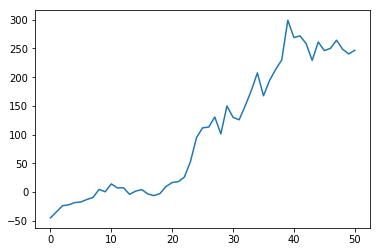

In [26]:
plt.plot(np.array(avg_fits)/100)

In [25]:
np.array(avg_fits)/100

array([-45.15914286, -34.53528571, -23.90185714, -22.31      ,
       -18.43128571, -17.39914286, -13.05942857,  -9.51485714,
         4.57042857,   0.33028571,  14.10271429,   7.10442857,
         7.30571429,  -4.06457143,   1.50457143,   4.19657143,
        -3.37028571,  -6.30328571,  -2.66971429,   9.64771429,
        16.49228571,  17.99257143,  25.82242857,  52.87414286,
        94.79685714, 111.77842857, 113.02971429, 130.65142857,
       101.24971429, 149.88242857, 130.10171429, 125.81057143,
       150.05142857, 176.67385714, 207.45942857, 167.622     ,
       194.23028571, 213.58542857, 230.093     , 299.21014286,
       268.98528571, 271.97628571, 258.66542857, 229.33885714,
       261.292     , 246.38028571, 250.16028571, 264.42914286,
       248.81371429, 240.513     , 246.87428571])

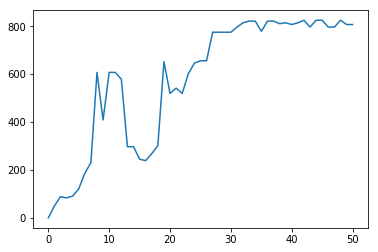

In [20]:
plt.plot(max_fits)